In [ ]:
!pip install gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LEVEL 1/torch')
from multiclass_functions2 import * # my module import # * 은 all을 의미
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import zipfile
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cuda


In [ ]:
# for random seed (여러분들과 제가 똑같은 결과를 보기 위한 설정)
import numpy as np
import random
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
BATCH_SIZE = 1
LR = 1e-3
LR_STEP = 2
LR_GAMMA = 0.9
LAMBDA = 1e-6
EPOCH = 10
criterion = nn.CrossEntropyLoss()
data_download = False # 최초 1회만 True로

new_model_train = False
hyuk_model_use = True # 여러분만의 모델 만들어서 사용하고 싶다면 False로
if hyuk_model_use:
    !gdown https://drive.google.com/uc?id=1-jQ_vGjhd8aIom6VhYQDUnx4ADByPLwm -O CNN_deep_COVID.pt
    !gdown https://drive.google.com/uc?id=1-0bd2pmBOU4FTt7FJiIkLDyCnokM1cfe -O CNN_deep_history_COVID.pt
    save_model_path = 'CNN_deep_COVID.pt'
    save_history_path = 'CNN_deep_history_COVID.pt'
else:
    save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/CNN_deep2_COVID.pt'
    save_history_path = '/content/drive/MyDrive/Colab Notebooks/results/CNN_deep2_history_COVID.pt'

Downloading...
From: https://drive.google.com/uc?id=1-jQ_vGjhd8aIom6VhYQDUnx4ADByPLwm
To: /content/CNN_deep_COVID.pt
100% 6.12M/6.12M [00:00<00:00, 69.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0bd2pmBOU4FTt7FJiIkLDyCnokM1cfe
To: /content/CNN_deep_history_COVID.pt
100% 973/973 [00:00<00:00, 4.42MB/s]


In [ ]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(32,32)),
    transforms.RandomAffine(degrees=(0,30),translate=(0.1,0.3),scale=(0.5,1.2)),
    transforms.ToTensor()])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(32,32)),
    transforms.ToTensor()])

In [ ]:
# COVID 데이터 출처: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

if data_download:
    !gdown https://drive.google.com/uc?id=1xlLqQ8p0CKSCfzKmKM_HiUHjd9KDSBAJ -O data.zip

    zip_path = "data.zip"  # 압축 파일 경로
    extract_path = "/content/drive/MyDrive/Colab Notebooks/data"  # 압축 해제할 경로

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

DS = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/data/COVID-19_Radiography_Dataset')

train_size = int(0.8 * len(DS))
val_size = int(0.1 * len(DS))
test_size = len(DS) - train_size - val_size
train_DS, val_DS, test_DS = random_split(DS, [train_size, val_size, test_size])

train_DS = SubsetWithTransform(train_DS, transform=transform_train)
val_DS = SubsetWithTransform(val_DS, transform=transform_test)
test_DS = SubsetWithTransform(test_DS, transform=transform_test)

print(test_DS.subset.dataset.classes)
test_DS.classes = test_DS.subset.dataset.classes
# 실제론 test_DS.subset.dataset.classes에 classes가 들어가 있지만
# 기존의 짜놓은 함수를 그대로 사용하기 위해 여기에도 classes를 만들어 넣음

BATCH_SIZE = 32
train_DL = DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

['Negative', 'Positive']


In [ ]:
print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

11046
1380
1382


In [ ]:
print(train_DL.dataset.transform)
print(test_DL.dataset.transform)
print(test_DL.dataset.classes)

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    RandomAffine(degrees=[0.0, 30.0], translate=(0.1, 0.3), scale=(0.5, 1.2))
    ToTensor()
)
Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)
['Negative', 'Positive']


torch.Size([32, 1, 32, 32])
Negative


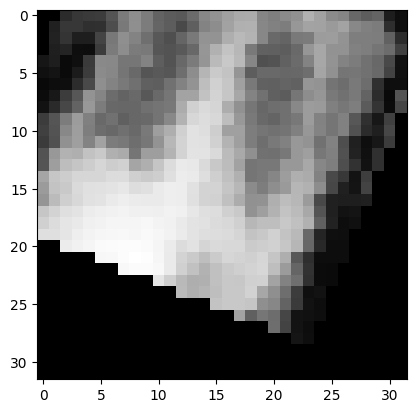

In [ ]:
x_batch, y_batch = next(iter(train_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0), cmap='gray')
print(test_DS.classes[y_batch[0]])

torch.Size([32, 1, 32, 32])
Positive


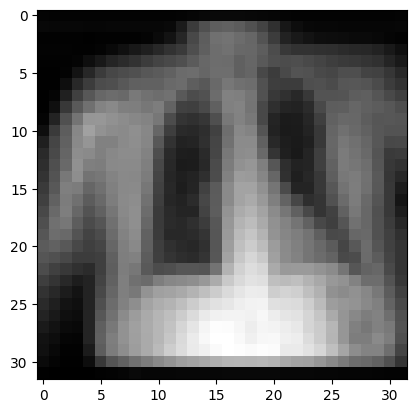

In [ ]:
x_batch, y_batch = next(iter(test_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0), cmap='gray')
print(test_DS.classes[y_batch[0]])

In [ ]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(1,32,3,padding=1, bias=False),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1, bias=False),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)
        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*4*4,512),
                                        nn.ReLU(),
                                        nn.Linear(512,2))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [ ]:
model = CNN_deep().to(DEVICE)
print(model)

x_batch, _ = next(iter(train_DL))
print(x_batch.shape)

model.eval()
with torch.no_grad():
    print(model(x_batch.to(DEVICE)).shape)

torch.Size([32, 1, 32, 32])
torch.Size([32, 2])


In [ ]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # for transfer learning
    optimizer = optim.SGD(params, lr = LR, weight_decay=LAMBDA)

    Train(model, train_DL, val_DL, criterion, optimizer,
          EPOCH, BATCH_SIZE,
          save_model_path, save_history_path,
          LR_STEP = LR_STEP, LR_GAMMA = LR_GAMMA)

In [ ]:
loaded = torch.load(save_model_path, map_location=DEVICE, weights_only=False)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]
scheduler = loaded["scheduler"]

loaded = torch.load(save_history_path, map_location=DEVICE, weights_only=False)
loss_history = loaded["loss_history"]
acc_history = loaded["acc_history"]

print(ep)
print(optimizer)
print(scheduler.step_size)
print(scheduler.gamma)

9
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: False
    initial_lr: 0.001
    lr: 0.0006561000000000001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 1e-06
)
2
0.9


<ipython-input-14-26be6b0dad8d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(save_model_path, map_location=DEVICE)
<ipython-input-14-26be6b0dad8d>:7:

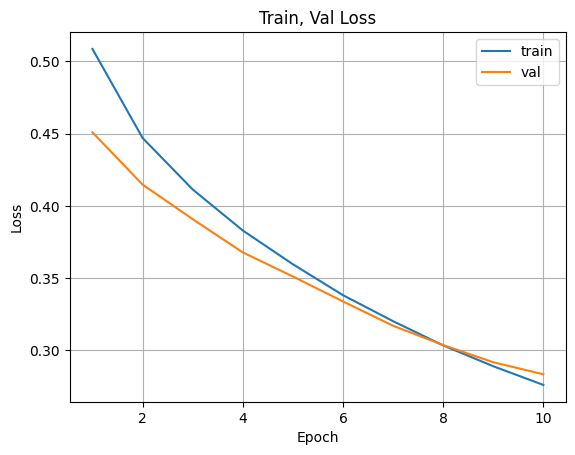

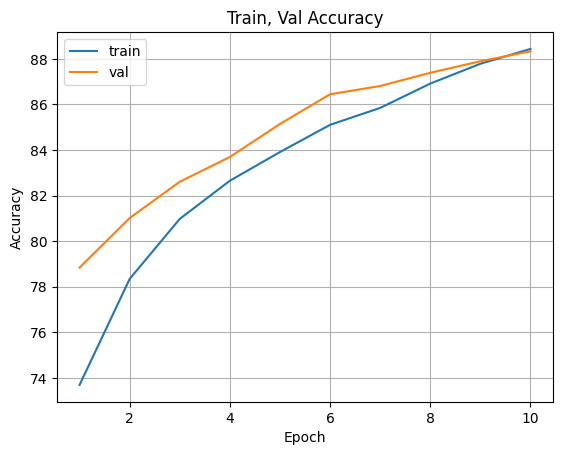

In [ ]:
plt.figure()
plt.plot(range(1,EPOCH+1), loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1), loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(range(1,EPOCH+1), acc_history["train"], label="train")
plt.plot(range(1,EPOCH+1), acc_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()
plt.grid()

In [ ]:
Test(load_model, test_DL, criterion)
print(count_params(load_model))


Test loss: 0.278
Test accuracy: 1232/1382 (89.1 %)
1521698


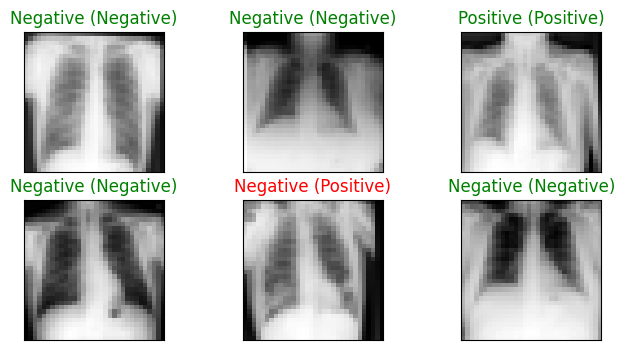

In [ ]:
Test_plot(load_model,test_DL)

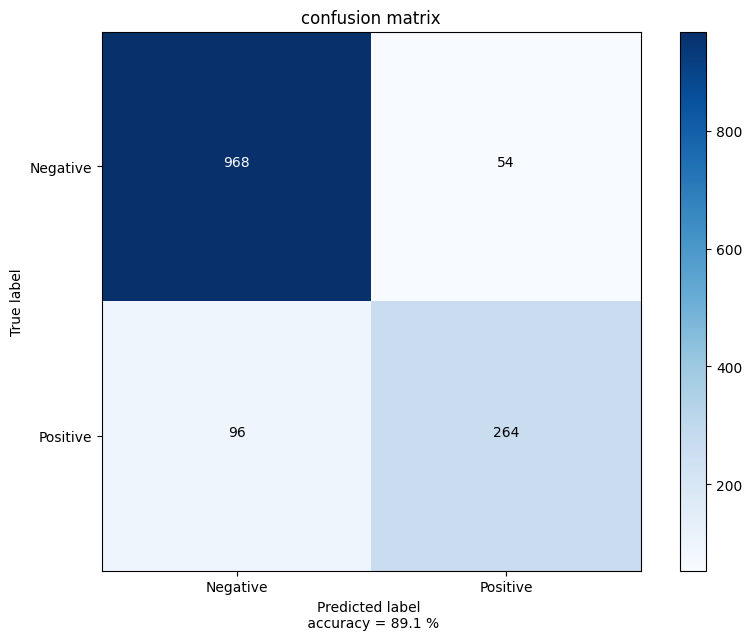

In [ ]:
confusion = get_conf(load_model, test_DL)
plot_confusion_matrix(confusion, test_DS.classes)

In [ ]:
recall, precision, f1 = calculate_recall_precision_f1(confusion)
print(f'recall = {recall[1]*100:.2f}')
print(f'precision = {precision[1]*100:.2f}')
print(f'f1 score = {f1[1]*100:.2f}')

recall = 73.33
precision = 83.02
f1 score = 77.88
